In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
path = '/nfs/team283/aa16/'
from matplotlib import rcParams
import seaborn as sns
# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Loading data and metadata

In [5]:
# Let's load the data and metadata from our Nanostring experiment:

counts = pd.read_table(path + 'KR_NAS/data/Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
subset_genes = np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288
counts = counts[subset_genes]
metadata = pd.read_csv(path + 'KR_NAS/data/NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table(path + 'KR_NAS/data/Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))]
negProbes = pd.read_csv(path + 'KR_NAS/data/Sanger_dedup_withNegProbes.csv')
negProbes = negProbes.loc[negProbes.iloc[:,0] == 'NegProbe-WTX',]
genes = negProbes['Unnamed: 0']
negProbes = negProbes.drop('Unnamed: 0',1)
negProbes = negProbes.rename(index=genes)
negProbes = negProbes.astype('int')
negProbes = negProbes[counts.keys()]
polioudakis = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/cellStateMatrix.csv')
genes = polioudakis.iloc[:,0]
polioudakis = polioudakis.drop('Unnamed: 0',1)
polioudakis = polioudakis.rename(index=genes)

# Choose which ROIs and genes to use, e.g. top 100 markers of each cell type:
rSlides = ('00MU', '00MV', '00MV-2')
markers = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/clusterMarkers.csv')

N = 100
columnNames = np.unique(markers['cluster'])
topN_markers = pd.DataFrame(index=range(N), columns=columnNames)
for i in range(len(columnNames)):
    topN_temp = np.array(markers[markers['cluster'] == columnNames[i]].iloc[0:N,].iloc[:,0])
    topN_markers[columnNames[i]] = [topN_temp[i].split('.')[0] for i in range(len(topN_temp))]
genes_new = np.array(topN_markers).flatten()  

subset = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')
                            for i in range(len(metadata['slide']))])[0]

Y_data = np.array(negProbes.iloc[:,subset]).T
counts_subset = counts.iloc[:,subset]
# subset_genes = [counts_subset.index[i] in genes_new for i in range(len(counts_subset.index))]
# counts_subset = counts_subset.iloc[subset_genes,:]
cellstateMatrix = polioudakis.reindex(np.array(counts_subset.index))
n_nuclei = np.array(properties['nuclei'])[subset]

Plot the mean negative counts as a function of various covariates, suggests total gene counts as the most important one:

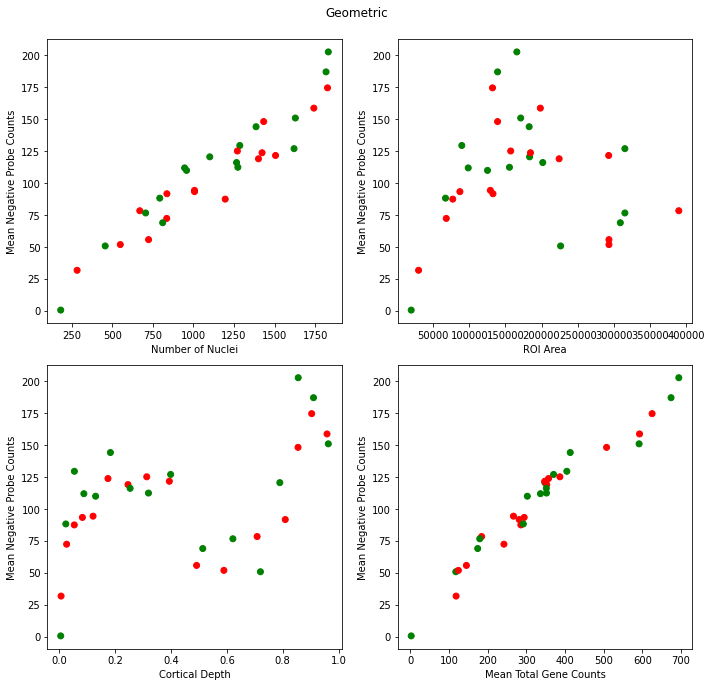

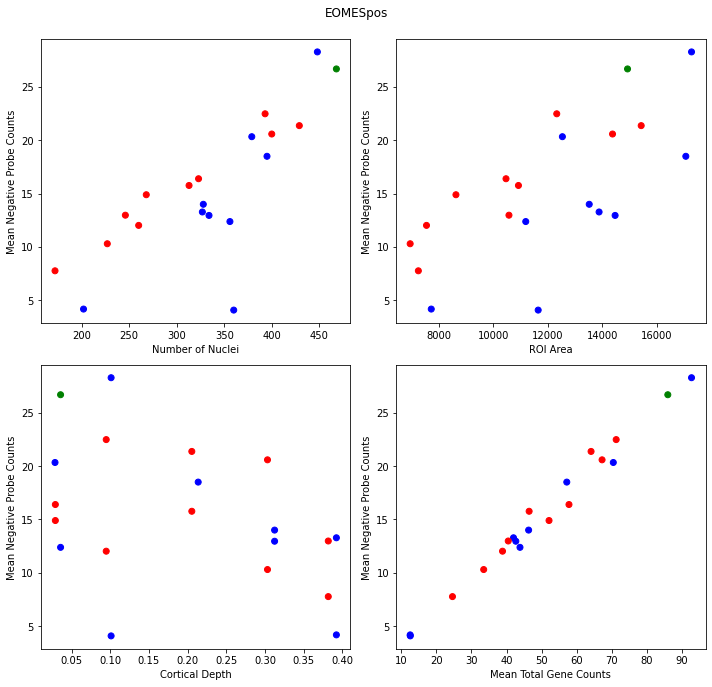

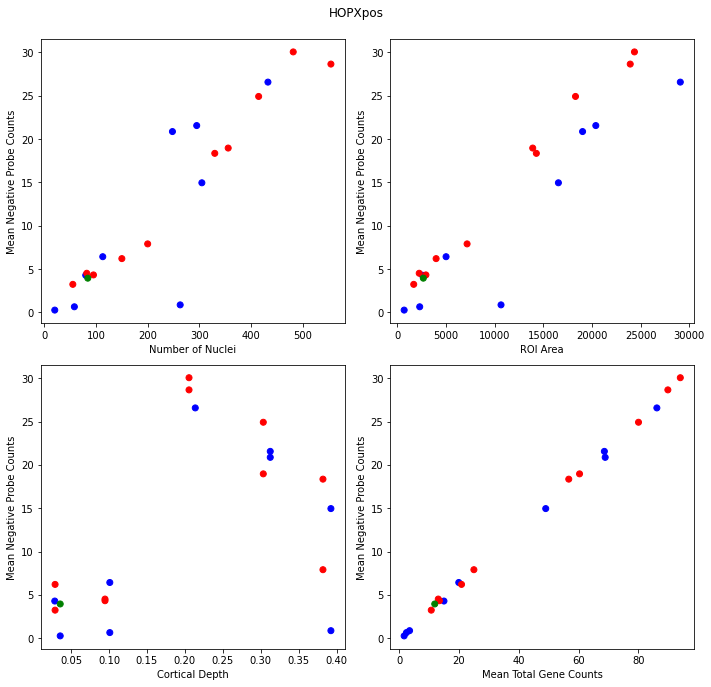

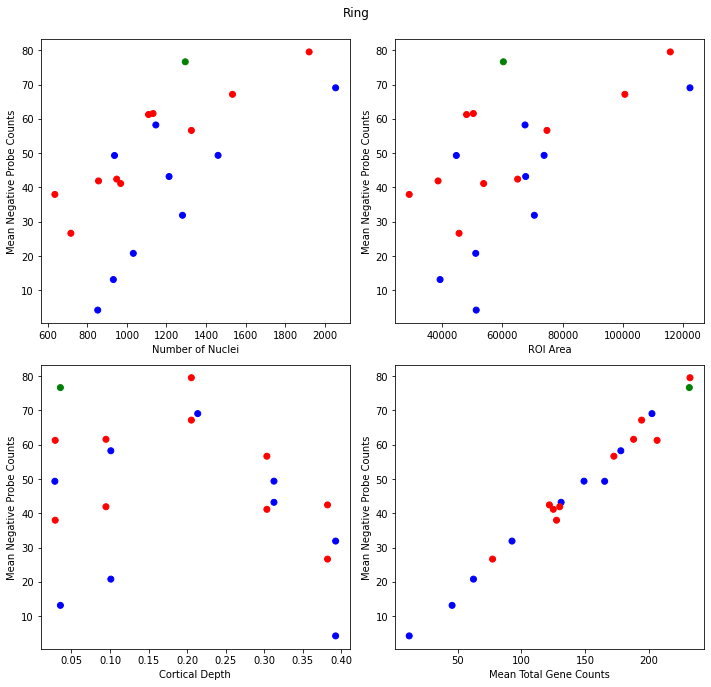

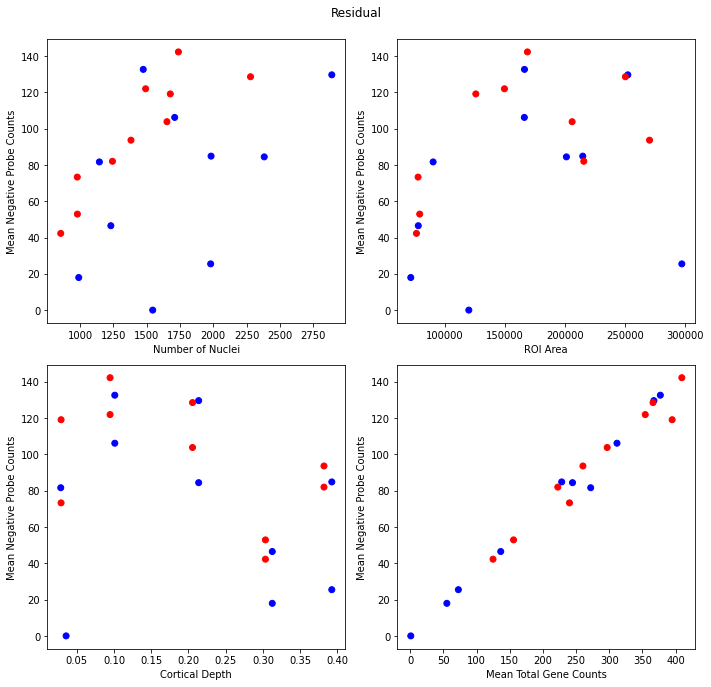

In [6]:
# Let's look at the background counts in our different types of 19pcw ROIs/AOIs:

rSlides = ('00MU', '00MV', '00MV-2')
subsets = []
types = ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')

subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] == 2
                   and metadata['AOI_type'][i] == types[0] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[1] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[2] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[3] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[4] for i in range(len(metadata['slide']))]))

for x in range(5):
    geneTotal = np.array([np.mean(counts.iloc[:,i]) for i in subsets[x]])
    negTotal = np.array([np.mean(negProbes.iloc[:,i]) for i in subsets[x]])
    numNuclei = np.array(properties['nuclei'])[subsets[x]]
    roiDim = np.array(properties['roi_dimension'])[subsets[x]]
    vcDepth = np.array(metadata['VCDepth'])[subsets[x]]
    slide = np.array(metadata['slide'])[subsets[x]]
    pcw = np.array(metadata['age'])[subsets[x]]
    
    colour = np.repeat('green', len(subsets[x][0]))
    colour[slide == '00MU'] = 'red'
    colour[slide == '00MV-2'] = 'blue'
    
    fig, ax = plt.subplots(2, 2, figsize = (10,10))
    ax[0,0].scatter(numNuclei, negTotal, c = colour)
    ax[0,0].set_ylabel('Mean Negative Probe Counts')
    ax[0,0].set_xlabel('Number of Nuclei')
    ax[0,1].scatter(roiDim, negTotal, c = colour)
    ax[0,1].set_ylabel('Mean Negative Probe Counts')
    ax[0,1].set_xlabel('ROI Area')
    ax[1,0].scatter(vcDepth, negTotal, c = colour)
    ax[1,0].set_ylabel('Mean Negative Probe Counts')
    ax[1,0].set_xlabel('Cortical Depth')
    ax[1,1].scatter(geneTotal, negTotal, c = colour)
    ax[1,1].set_ylabel('Mean Negative Probe Counts')
    ax[1,1].set_xlabel('Mean Total Gene Counts')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(types[x])
    fig.savefig(types[x] + '.pdf')


Check if some negative probes have consistently higher counts than others:

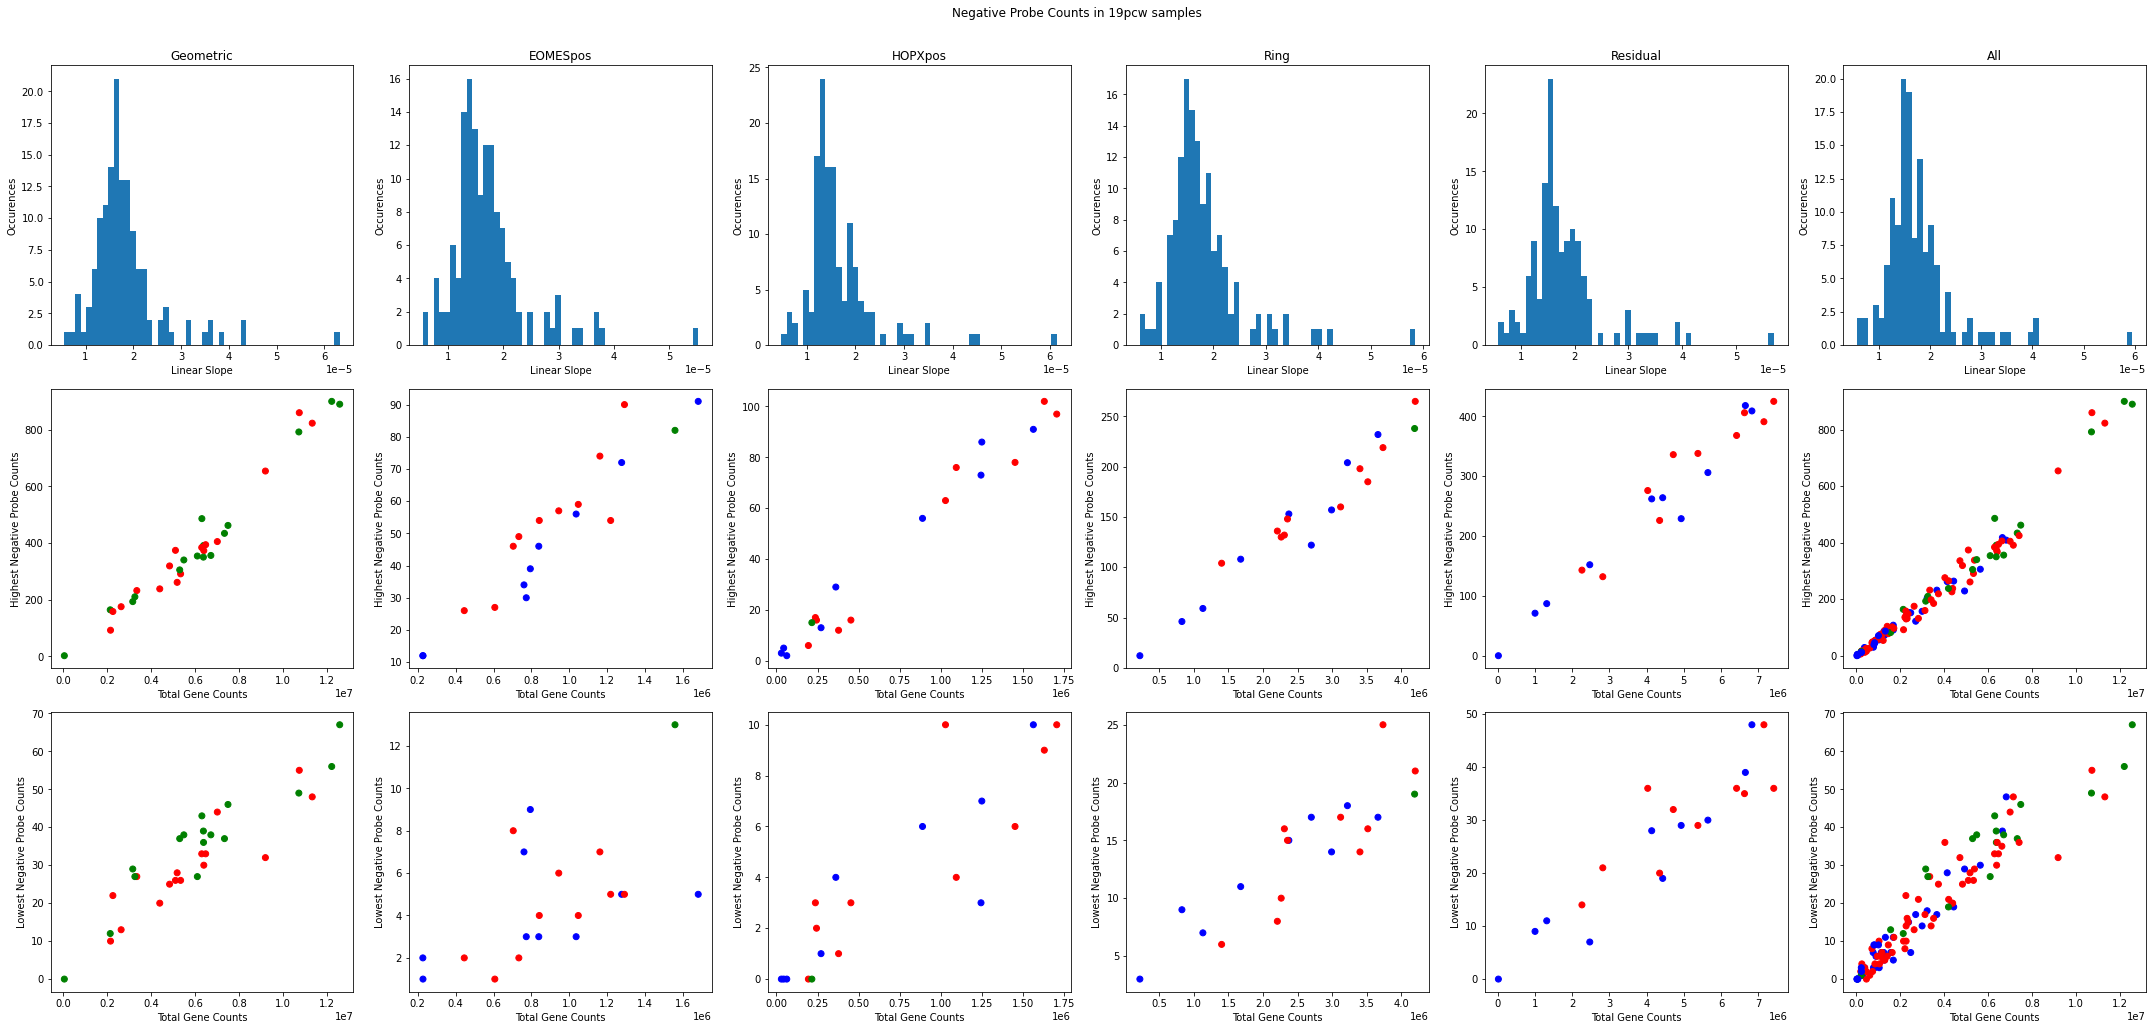

In [7]:
rSlides = ('00MU', '00MV', '00MV-2')
subsets = []
types = ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual', 'All')

subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] == 2
                   and metadata['AOI_type'][i] == types[0] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[1] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[2] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[3] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[4] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in types for i in range(len(metadata['slide']))]))

fig, ax = plt.subplots(3, 6, figsize = (30,15))
for x in range(6):
    geneTotal = np.array([np.sum(counts.iloc[:,i]) for i in subsets[x]])[0]
    negMean = np.array([np.mean(negProbes.iloc[:,i]) for i in subsets[x]])[0]
    normCounts = np.array([np.array(negProbes.iloc[:,subsets[x][0][i]]/geneTotal[i]) for i in range(len(subsets[x][0]))])
    normMean = [np.mean(normCounts[:,i]) for i in range(np.shape(normCounts)[1])]
    
    top = np.argmax(normMean)
    bottom = np.argmin(normMean)

    negTop = np.array([negProbes.iloc[top,i] for i in subsets[x]])[0]
    negBottom = np.array([negProbes.iloc[bottom,i] for i in subsets[x]])[0]

    slide = np.array(metadata['slide'])[subsets[x]]

    colour = np.repeat('green', len(subsets[x][0]))
    colour[slide == '00MU'] = 'red'
    colour[slide == '00MV-2'] = 'blue'

    ax[0,x].hist(normMean, bins = 50)
    ax[0,x].set_xlabel('Linear Slope')
    ax[0,x].set_ylabel('Occurences')
    ax[0,x].set_title(types[x])
    ax[1,x].scatter(geneTotal, negTop, c = colour)
    ax[1,x].set_ylabel('Highest Negative Probe Counts')
    ax[1,x].set_xlabel('Total Gene Counts')
    ax[2,x].scatter(geneTotal, negBottom, c = colour)
    ax[2,x].set_ylabel('Lowest Negative Probe Counts')
    ax[2,x].set_xlabel('Total Gene Counts')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Negative Probe Counts in 19pcw samples')
    fig.savefig(types[x] + '.pdf')



In [8]:
print(min(normMean))
print(max(normMean))

5.734898798669709e-06
5.950745058565973e-05


Based on this make a generative model of probe counts:

In [9]:
# -*- coding: utf-8 -*-
"""Default Generative Model for GeoMx counts"""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from functools import wraps

from pycell2location.models.pymc3_model import Pymc3Model 

# defining the model itself
class GeoMxCounts(Pymc3Model):
    r"""GeoMx background noise model
    :param X_data: Numpy array of negative probe counts (cols) in ROIs (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    """

    def __init__(
        self,
        X_data: np.ndarray,
        Y_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 200000,
        learning_rate = 0.001,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        n_components = 20,
        cutoff_poisson = 1000,
        h_alpha = 1
    ):
        
        ############# Initialise parameters ################
        super().__init__(X_data, 0,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose)
        self.Y_data = Y_data
        self.y_data = theano.shared(Y_data.astype(self.data_type))
        self.n_rois = Y_data.shape[0]
        self.l_r = np.array([np.sum(X_data[i,:]) for i in range(self.n_rois)]).reshape(self.n_rois,1)*10**(-5)
        self.n_components = n_components
        self.n_npro = Y_data.shape[1]
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        self.X_data1 = self.X_data[self.poisson_residual]
        self.X_data2 = self.X_data[self.gamma_residual]
        self.genes = var_names
        self.sample_names = obs_names
        self.h_alpha = h_alpha
        
        ############# Define the model ################
        self.model = pm.Model()
        with self.model:
            
            ### Negative Probe Counts ###
            
            # Prior for distribution of negative probe count levels:
            self.b_n_hyper = pm.Gamma('b_n_hyper', alpha = np.array((3000,500)), beta = np.array((1000,1000)), shape = 2)
            # The distribution of negative probe count levels:
            self.b_n = pm.Gamma('b_n', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_npro))
            # The expected mean of each negative probe based on its count level and total counts in this roi:
            self.y_rn = self.b_n*self.l_r
            
            ### Gene Counts ###
            
            # Background for gene probes, drawn from the same distribution as negative probes:
            self.b_g = pm.Gamma('b_g', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_genes))

            # Gene expression modeled as combination of non-negative components:
            self.h = pm.Dirichlet('h', a=np.ones(self.n_components)*self.h_alpha, shape=(self.n_genes, self.n_components))
            self.gene_level_hyp = pm.Gamma('gene_level_hyp', 1, 1, shape=2)
            self.gene_level = pm.Gamma('gene_level', self.gene_level_hyp[0],
                                       self.gene_level_hyp[1], shape=(self.n_genes, 1))
            self.w_hyp = pm.Gamma('w_hyp', np.array((1,1)), np.array((1,1)), shape=(self.n_components,2))
            self.w = pm.Gamma('w', mu=self.w_hyp[:,0], sigma=self.w_hyp[:,1], shape=(self.n_rois, self.n_components))
            self.a_gr =  pm.Deterministic('a_gr', pm.math.dot(self.w, self.h.T)*self.gene_level.T)
            
            # Expected gene counts are sum of gene expression and background counts, scaled by library size:
            self.x_rg = (self.a_gr + self.b_g)*self.l_r
            
            self.data_target = pm.DensityDist('data_target', self.get_logDensity, observed=tt.concatenate([self.y_data, self.x_data], axis = 1))
        
    def get_logDensity(self,x):
            mu1 = self.y_rn
            mu2 = self.x_rg[self.poisson_residual]
            mu3 = self.x_rg[self.gamma_residual]
            logDensity = tt.sum(pm.Poisson.dist(mu1).logp(x[:,:self.n_npro])) + tt.sum(pm.Poisson.dist(mu2).logp(x[:,self.n_npro:][self.poisson_residual])) + tt.sum(pm.Gamma.dist(mu = mu3, sd = np.sqrt(mu3)).logp(x[:,self.n_npro:][self.gamma_residual]))
            return logDensity

    def plot_prior_vs_data(self, data_target_name=('data_target0', 'data_target1', 'data_target2'),
                           data_node=('Y_data', 'X_data1', 'X_data2')):
        r""" Plot data vs a single sample from the prior in a 2D histogram
        Uses self.X_data and self.prior_trace['data_target'].
        :param data_node: name of the object slot containing data
        """
        
        if len(data_node) == 1:
            data_node = getattr(self, data_node)
            plt.hist2d(np.log10(data_node.flatten()+1),
            np.log10(self.prior_trace[data_target_name].flatten()+1),
            bins = 50, norm=matplotlib.colors.LogNorm())
            plt.xlabel('Data, log10(nUMI)')
            plt.ylabel('Prior sample, log10(nUMI)')
            plt.title('UMI counts (all spots, all genes)')
            plt.tight_layout()
        else:
            data_node_list = []
            for i in range(len(data_node)):
                data_node_list.append(getattr(self, data_node[i]))
            fig, ax = plt.subplots(1, 3, figsize = (30,10))
            for i in range(len(data_node_list)):
                ax[i].hist2d(np.log10(data_node_list[i].flatten()+1),
                np.log10(self.prior_trace[data_target_name[i]].flatten()+1),
                bins = 50, norm=matplotlib.colors.LogNorm())
                ax[i].set_xlabel('Data, log10(nUMI)', fontsize=25)
                ax[i].set_ylabel('Prior sample, log10(nUMI)', fontsize=25)
                ax[i].set_title(data_target_name[i] + ': UMI counts (all spots, all genes)', fontsize=25)
                ax[i].tick_params(axis='both', which='major', labelsize=25)
                ax[i].tick_params(axis='both', which='minor', labelsize=25)

            plt.tight_layout()
    
    def compute_expected(self):
        r""" Save expected value of negative probe poisson mean and negative probe level"""
        # compute expected mean of negative probes:
        self.y_rn_mean = self.samples['post_sample_means']['b_n'] * self.l_r
        # compute expected mean of normalized gene probe counts:
        self.a_gr_mean = self.samples['post_sample_means']['a_gr']
        # compute expected mean of unnormalized gene probe counts:
        self.x_rg_mean = (self.samples['post_sample_means']['a_gr'] + self.samples['post_sample_means']['b_g'])*self.l_r
        
    def compute_logFC(self, groupA = 3, groupB = 6, n_samples = 1000):
        r"""Compute log-fold change of genes between two ROIs or two groups of ROIs, as well as associated
        standard deviation and 0.05 and 0.95 percentile"""
        groupA = np.squeeze(groupA)
        groupB = np.squeeze(groupB)
        post_sample_a_gr = self.mean_field['init_1'].sample_node(self.a_gr, size = n_samples).eval()
        self.logFC = pd.DataFrame(index = self.genes, columns = ('groupA', 'groupB', 'mean', 'sd', 'q05', 'q95'))
        
        if sum(np.shape(groupA)) < 2:
            groupA_value = np.log2(post_sample_a_gr[:,groupA,:])
            self.logFC['groupA'] = self.sample_names[groupA]
        else:
            groupA_value = np.log2(np.mean(post_sample_a_gr[:,groupA,:], axis = 1))
            self.logFC['groupA'] = ', '.join(self.sample_names[groupA])
        if sum(np.shape(groupB)) < 2:
            groupB_value = np.log2(post_sample_a_gr[:,groupB,:])
            self.logFC['groupB'] = self.sample_names[groupB]
        else:
            groupB_value = np.log2(np.mean(post_sample_a_gr[:,groupB,:], axis = 1))
            self.logFC['groupB'] = ', '.join(self.sample_names[groupB])
        
        self.logFC_sample =  groupA_value - groupB_value
        self.logFC['mean'] = self.logFC_sample.mean(axis=0)
        self.logFC['sd'] = self.logFC_sample.std(axis=0) 
        self.logFC['q05'] = np.quantile(self.logFC_sample, 0.05, axis=0)
        self.logFC['q95'] = np.quantile(self.logFC_sample, 0.95, axis=0)  
        
    def compute_FDR(self, logFC_threshold = 1):
        r"""Compute probability that logFC is above a certain threshold 
        and also include FDR for each probability level."""
        self.logFC['threshold'] = logFC_threshold
        self.logFC['probability'] = np.sum(np.abs(self.logFC_sample) > logFC_threshold, axis = 0)/np.shape(self.logFC_sample)[0]
        probability = self.logFC['probability']
        self.logFC['FDR'] = np.array([sum(1-probability[probability >= p])/sum(probability >= p) for p in probability])
        self.logFC = self.logFC.sort_values('FDR')
    
    #def plot_module_weights(self)
    
    #def plot_module_genes(self)
    
    #def plot_volcano(self)
    
    

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


Run model on good ROIs in 19pcw sample:

In [10]:
rSlides = ('00MU', '00MV', '00MV-2')

subset = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')
                            for i in range(len(metadata['slide']))])[0]

X_data = np.array(counts_subset).T
Y_data = np.array(negProbes.iloc[:,subset]).T
negProbes_subset = np.array(negProbes.iloc[:,subset])

In [11]:
metadata_subset = metadata.iloc[subset,:]
print(np.where(metadata_subset['AOI_type'] == 'EOMESpos'))
print(np.where(metadata_subset['AOI_type'] == 'HOPXpos'))

(array([  0,   3,   4,  11,  12,  19,  20,  36,  37,  38,  59,  60,  61,
        83,  84,  85,  86,  88, 103, 105]),)
(array([  5,   6,  13,  14,  21,  22,  23,  42,  43,  44,  65,  66,  67,
        90,  91,  92,  93,  95, 106, 109]),)


In [12]:
mod1 = GeoMxCounts(
        X_data, Y_data,
        data_type='float32', n_iter=100000,
        learning_rate=0.001,
        total_grad_norm_constraint=200,
        verbose=False, var_names= np.array(counts_subset.index), obs_names=np.array(counts_subset.keys()))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-563648e5e15d>", line 6, in <module>
    verbose=False, var_names= np.array(counts_subset.index), obs_names=np.array(counts_subset.keys()))
  File "<ipython-input-9-416bcfb2dcad>", line 99, in __init__
    self.data_target = pm.DensityDist('data_target', self.get_logDensity, observed=tt.concatenate([self.y_data, self.x_data], axis = 1))
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/theano/tensor/basic.py", line 4753, in concatenate
    return join(axis, *tensor_list)
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/theano/tensor/basic.py", line 4502, in join
    return join_(axis, *tensors_list)
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/theano/gof/op.py", line 615, in __cal

KeyboardInterrupt: 

In [17]:
#mod1.sample_prior()
#mod1.plot_prior_vs_data()

In [151]:
mod0.fit_advi(n=1, method='advi')

Average Loss = 56,592: 100%|██████████| 20000/20000 [00:15<00:00, 1270.70it/s]   
Finished [100%]: Average Loss = 56,592


In [143]:
mod1.fit_advi(n=1, method='advi')

Average Loss = 9.0853e+06:  14%|█▍        | 14216/100000 [1:01:16<6:06:13,  3.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 7.7415e+06:  27%|██▋       | 26510/100000 [1:54:07<5:15:36,  3.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 7.7025e+06:  38%|███▊      | 38005/100000 [2:43:31<4:24:26,  3.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the cl

In [144]:
#pickle.dump(mod1x, file = open( "mod1.p", "wb" ))

In [13]:
mod1 = pickle.load( open( "mod1.p", "rb" ) )

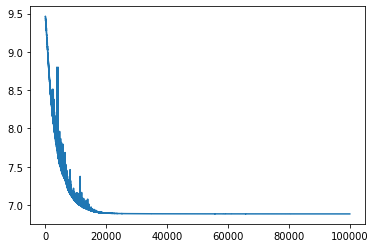

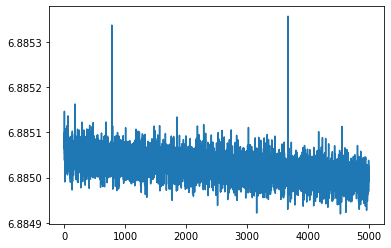

In [14]:
mod1.plot_history()
plt.show()
mod1.plot_history(mod1.n_iter-5000)

In [15]:
mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);
mod1.compute_expected()

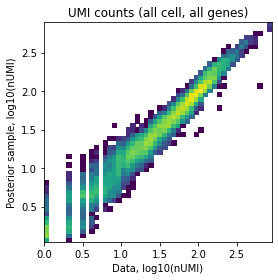

In [16]:
mod1.plot_posterior_mu_vs_data(mu_node_name='y_rn_mean', data_node='Y_data')

In [18]:
import theano
theano.config.compute_test_value = 'ignore'
mod1.compute_logFC(groupA = np.squeeze(np.where(metadata_subset['AOI_type'] == 'EOMESpos')),
                   groupB = np.squeeze(np.where(metadata_subset['AOI_type'] == 'HOPXpos')),
                   n_samples = 1000)
# mod1.compute_logFC(groupA = np.array((3)),
#                    groupB = np.array((6)),
#                    n_samples = 1000)
mod1.compute_FDR(logFC_threshold = 1)

In [15]:
mod1.logFC

groupA  \
H2BU1       HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
H2BC3       HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
H2AC8       HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
EOMES       HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
H4C13       HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
...                                                       ...   
ASNS        HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
IFI27L2     HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
OBSCN       HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
IDUA        HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   
KRTAP10-10  HCA_F_BRA8739081, HCA_F_BRA8739095, HCA_F_BRA8...   

                                                       groupB      mean  \
H2BU1       HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8...  1.358232   
H2BC3       HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8...  1.760228   
H2AC8       HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8...  1.335820   
EOMES       HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8...  1.273404   
H4C13       HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8...  1.239497   
...                                                       ...       ...   
ASNS        HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8... -0.425696   
IFI27L2     HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8... -0.483059   
OBSCN       HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8... -0.030532   
IDUA        HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8... -0.528342   
KRTAP10-10  HCA_F_BRA8739103, HCA_F_BRA8739104, HCA_F_BRA8... -0.519969   

                  sd       q05       q95  threshold  probability       FDR  
H2BU1       0.050637  1.298873  1.411353          1          1.0  0.000000  
H2BC3       0.049729  1.701355  1.817166          1          1.0  0.000000  
H2AC8       0.038939  1.316614  1.352845          1          1.0  0.000000  
EOMES       0.052944  1.224201  1.314475          1          1.0  0.000000  
H4C13       0.049088  1.186865  1.289955          1          1.0  0.000000  
...              ...       ...       ...        ...          ...       ...  
ASNS        0.123138 -0.617144 -0.223562          1          0.0  0.944936  
IFI27L2     0.072373 -0.579968 -0.389385          1          0.0  0.944936  
OBSCN       0.143238 -0.277049  0.182648          1          0.0  0.944936  
IDUA        0.144194 -0.769109 -0.314748          1          0.0  0.944936  
KRTAP10-10  0.143034 -0.736739 -0.292938          1          0.0  0.944936  

[18119 rows x 9 columns]

In [468]:
genesOfInterest = np.array(['FOS', 'EGR1', 'HES1', 'VIM', 'PTN', 'PEA15',
       'SLC1A3', 'NRG1', 'PPP1R17', 'SSTR2', 'EOMES', 'NHLH1', 'PENK',
       'TMEM158', 'HES6', 'CORO1C', 'CA12'])

In [475]:
# Set figure parameters:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [469]:
geneIndex_to_annotate = np.squeeze([np.where(mod1.logFC.index == genesOfInterest[i]) for i in range(len(genesOfInterest))])

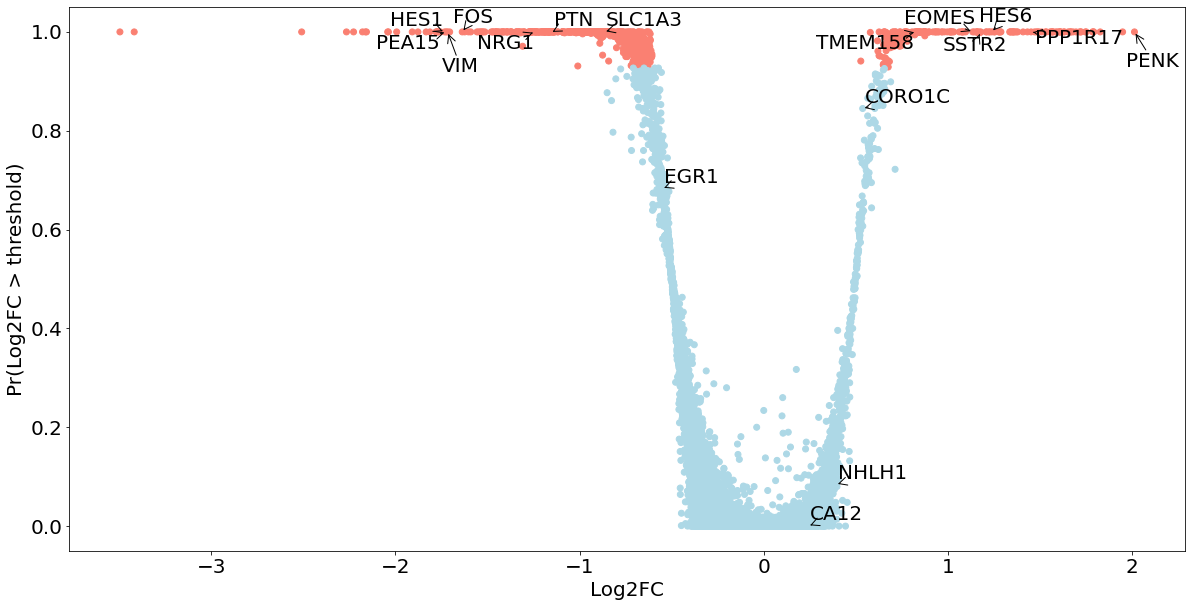

In [476]:
from adjustText import adjust_text
plt.figure(figsize=(20,10))
colours = np.repeat('lightblue', mod1.n_genes)
colours[mod1.logFC['FDR'] < 0.01] = 'salmon'
plt.scatter(mod1.logFC['mean'], mod1.logFC['probability'], c=colours)
plt.xlabel('Log2FC')
plt.ylabel('Pr(Log2FC > threshold)')

ts = []    
for i,j in enumerate(geneIndex_to_annotate):
    ts.append(plt.text(mod1.logFC['mean'][j], mod1.logFC['probability'][j], genesOfInterest[i]))
adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'))
plt.show()

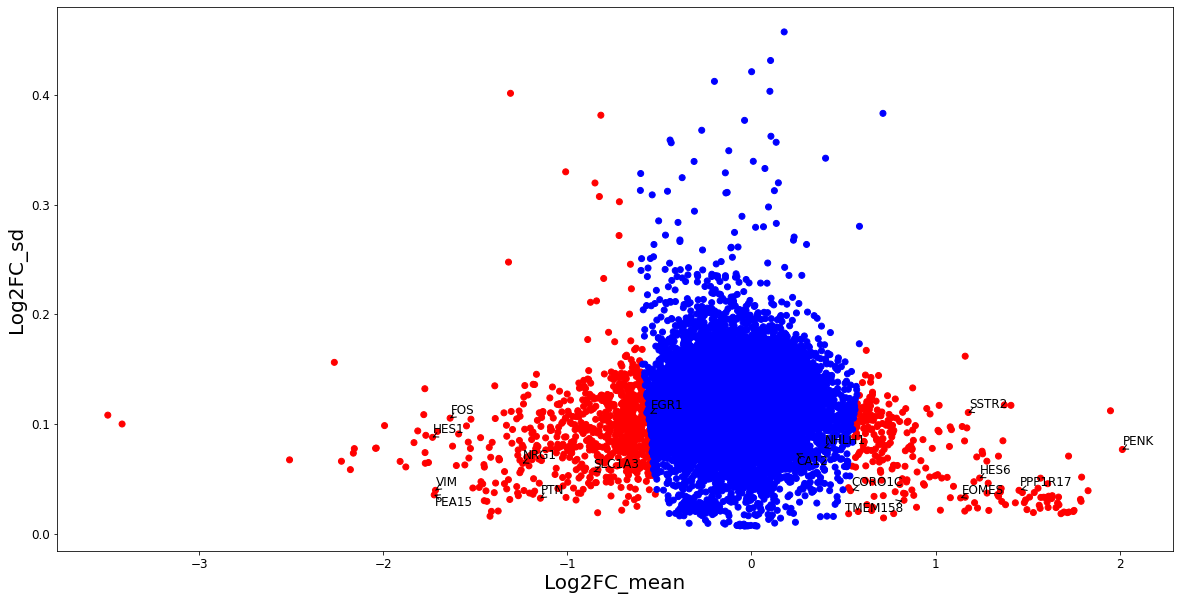

In [472]:
plt.figure(figsize=(20,10))
colours = np.repeat('blue', mod1.n_genes)
colours[mod1.logFC['FDR'] < 0.05] = 'red'
plt.scatter(mod1.logFC['mean'], mod1.logFC['sd'], c = colours)
plt.xlabel('Log2FC_mean')
plt.ylabel('Log2FC_sd')    
ts = []    
for i,j in enumerate(geneIndex_to_annotate):
    ts.append(plt.text(mod1.logFC['mean'][j], mod1.logFC['sd'][j], genesOfInterest[i]))
adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'))
plt.show()

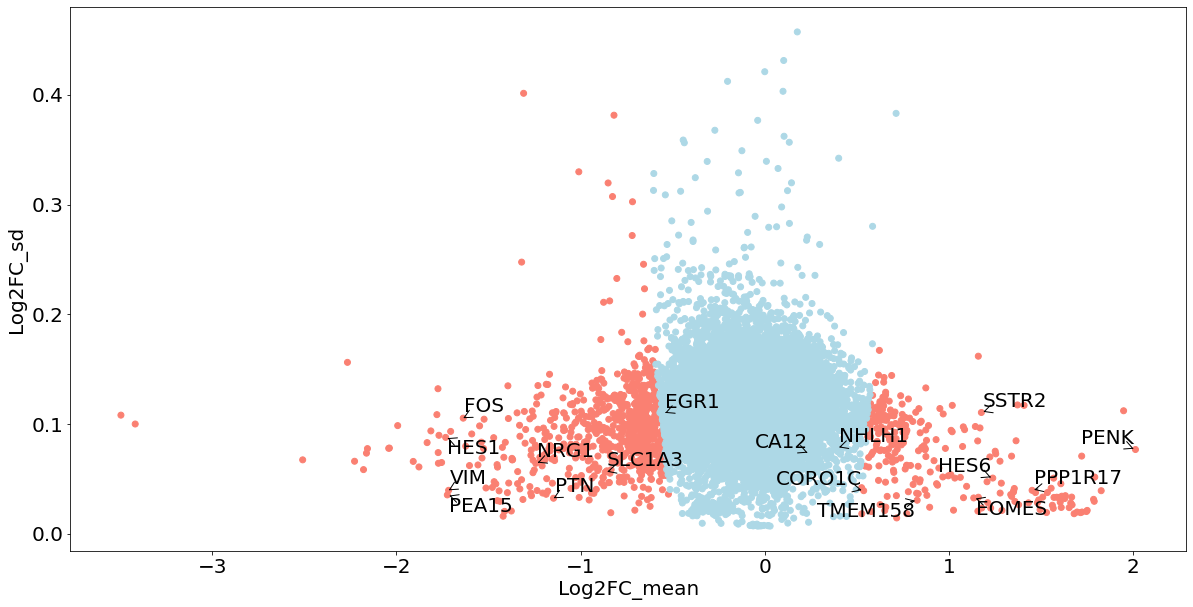

In [477]:
f = plt.figure(figsize=(20,10))
colours = np.repeat('lightblue', mod1.n_genes)
colours[mod1.logFC['FDR'] < 0.05] = 'salmon'
plt.scatter(mod1.logFC['mean'], mod1.logFC['sd'], c = colours)
plt.xlabel('Log2FC_mean')
plt.ylabel('Log2FC_sd')    
ts = []    
for i,j in enumerate(geneIndex_to_annotate):
    ts.append(plt.text(mod1.logFC['mean'][j], mod1.logFC['sd'][j], genesOfInterest[i]))
adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 1.5, force_objects = 1, force_points = 1)
f.savefig('LogFoldChange_MeanVsSD_ScatterPlot.pdf')

In [408]:
n_samples = 1000
n_times = 10

In [409]:
post_sample_a_gr = mod1.mean_field['init_1'].sample_node(mod1.a_gr, size = n_samples).eval()

In [410]:
post_sample_b_g = mod1.mean_field['init_1'].sample_node(mod1.b_g, size = n_samples).eval()

In [411]:
post_sample_b_n = mod1.mean_field['init_1'].sample_node(mod1.b_n, size = n_samples).eval()

In [412]:
post_sample_b_n_hyper = mod1.samples['post_sample_means']['b_n_hyper']
post_sample_b_n_hyper

array([0.22646105, 0.1455449 ], dtype=float32)

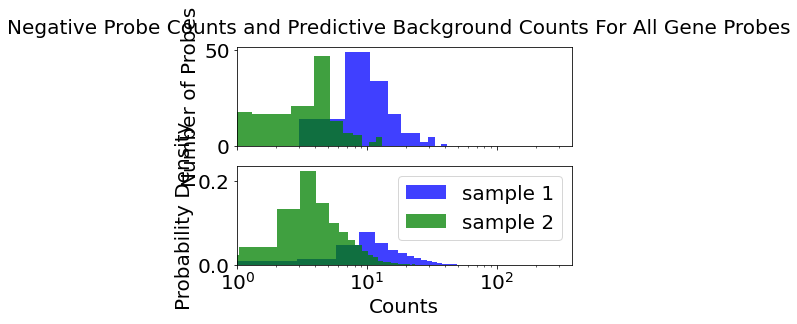

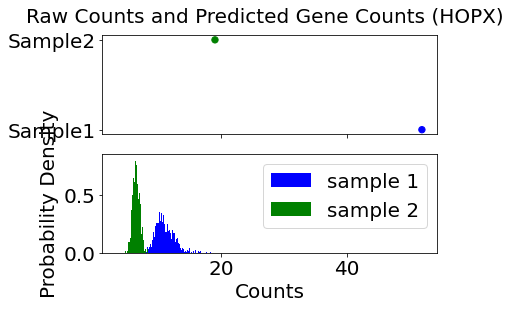

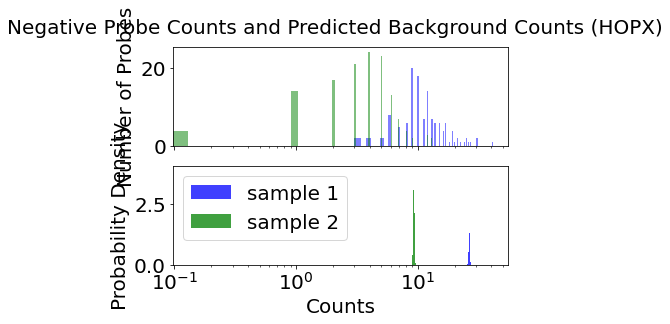

In [413]:
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Negative Probe Counts and Predictive Background Counts For All Gene Probes')
ax[0].hist(negProbes_subset[:,3], color = 'blue', bins = 10, alpha = 0.75)
ax[0].hist(negProbes_subset[:,6], color = 'green', bins = 10, alpha = 0.75)
ax[0].set_ylabel('Number of Probes')
ax[1].hist(np.squeeze(post_sample_b_g[:,:,:]*mod0.l_r[3]).flatten(), bins = n_bins, density = True, label = 'sample 1', color = 'blue', alpha = 0.75)
ax[1].hist(np.squeeze(post_sample_b_g[:,:,:]*mod0.l_r[6]).flatten(), bins = n_bins, density = True, label = 'sample 2', color = 'green', alpha = 0.75)
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Probability Density')
ax[1].set_xscale('log')
ax[1].legend()

n_bins = 100
gene = 'HOPX'

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Raw Counts and Predicted Gene Counts (' + gene + ')')
ax[0].scatter(X_data[(3,6), mod1.genes == gene], ('Sample1','Sample2'),  40, c = ('blue', 'green'))
ax[1].hist(np.squeeze(post_sample_a_gr[:,3,mod1.genes == gene]*mod1.l_r[3]), bins = n_bins, density = True, label = 'sample 1', color = 'blue')
ax[1].hist(np.squeeze(post_sample_a_gr[:,6,mod1.genes == gene]*mod1.l_r[6]), bins = n_bins, density = True, label = 'sample 2', color = 'green')
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Probability Density')
ax[1].legend()

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Negative Probe Counts and Predicted Background Counts (' + gene + ')')
ax[0].hist(negProbes_subset[:,3], color = 'blue', bins = 100, alpha = 0.5)
ax[0].hist(negProbes_subset[:,6], color = 'green', bins = 100, alpha = 0.5)
ax[0].set_ylabel('Number of Probes')
ax[1].hist(np.squeeze(post_sample_b_g[:,:, mod0.genes == gene]*mod0.l_r[3]), bins = 10, density = True, label = 'sample 1', color = 'blue', alpha = 0.75)
ax[1].hist(np.squeeze(post_sample_b_g[:,:, mod0.genes == gene]*mod0.l_r[6]), bins = 10, density = True, label = 'sample 2', color = 'green', alpha = 0.75)
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Probability Density')
ax[1].set_xscale('log')
ax[1].legend()

Now let's look at inferred components and enrichment for cell types and disease genes across cortical depth:

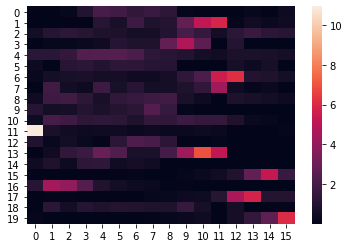

In [107]:
subset_w = np.where(np.array([metadata_subset['AOI_type'][i] == 'Geometric' and metadata_subset['slide'][i] == '00MU' for i in range(len(metadata_subset['AOI_type']))]))[0]
order = subset_w[np.argsort(metadata_subset['VCDepth'].iloc[subset_w])]

w = mod1.samples['post_sample_means']['w'][order,:]
sns.heatmap(w.T)
plt.savefig('w_heatmap.pdf', xticklabels=True, yticklabels=True)
# subset_w = np.where(np.array([metadata_subset['AOI_type'][i] == 'Geometric' and metadata_subset['slide'][i] == '00MV' for i in range(len(metadata_subset['AOI_type']))]))[0]
# order = subset_w[np.argsort(metadata_subset['VCDepth'].iloc[subset_w])]
# w = mod1.samples['post_sample_means']['w'][order,:]
# plt.show()
# sns.clustermap(w.T, col_cluster=False)
# plt.show()

['CCN1' 'CRYAB' 'CCN2' 'FOS' 'DDIT4' 'FAM162A' 'HES1' 'MID1' 'P3H2' 'LOX'
 'VIM']
['PDZRN3' 'DLX2' 'DLX5' 'PDZRN4' 'SOX1' 'RIPOR2' 'ERBB4' 'SP9' 'SCGN'
 'SP8' 'PROX1']


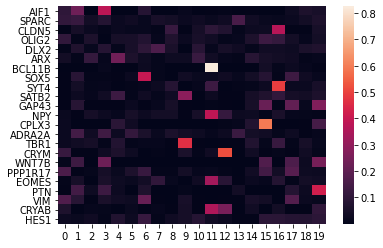

In [109]:
markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'VIM', 'PTN',
                          'EOMES', 'PPP1R17', 'WNT7B', 'CRYM','TBR1', 'ADRA2A', 'CPLX3', 'NPY', 'GAP43',
                          'SATB2', 'SYT4', 'SOX5', 'BCL11B',
                          'ARX', 'DLX2', 'OLIG2',
                          'CLDN5', 'SPARC','AIF1')))

h_normalized = mod1.samples['post_sample_means']['h']
h_normalized = np.array([h_normalized[i,:]/sum(h_normalized[i,:]) for i in range(np.shape(h_normalized)[0])])

print(mod1.genes[[np.argsort(-h_normalized[:,11])]][0:11])
h_normalized[:,11][np.argsort(-h_normalized[:,11])]
print(mod1.genes[[np.argsort(-h_normalized[:,16])]][0:11])
h_normalized[:,11][np.argsort(-h_normalized[:,11])]

h_subset = h_normalized[[mod1.genes[i] in markers_genes for i in range(len(mod1.genes))],:]
df = pd.DataFrame(h_subset, index=markers_genes)
sns.heatmap(np.log2(df), xticklabels=True, yticklabels=True)
plt.savefig('h_heatmap.pdf')

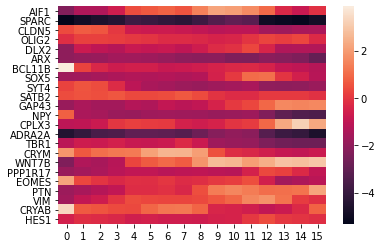

In [112]:
a_gr_subset = mod1.samples['post_sample_means']['a_gr'][:,[mod1.genes[i] in markers_genes for i in range(len(mod1.genes))]][order]
df = pd.DataFrame(np.log2(a_gr_subset.T), index=markers_genes)
sns.heatmap(df, xticklabels=True, yticklabels=True)
plt.savefig('a_gr_heatmap.pdf')

In [105]:
a_gr_subset

array([[ 0.19741312,  0.0249985 ,  1.3175056 ,  0.8868027 ,  0.24660869,
         0.24555771, 14.618902  ,  0.31238204,  1.2089648 ,  1.3459247 ,
         0.2809739 ,  1.7422982 ,  0.47899333,  0.04500525,  0.46254215,
         3.631459  ,  0.1927582 ,  0.28503466,  4.641522  ,  0.2940589 ,
         0.31780168, 10.475908  ,  0.68890417],
       [ 0.39174923,  0.03437728,  1.6426079 ,  1.1632407 ,  0.60306966,
         0.27008012,  1.1994728 ,  0.3173305 ,  1.5027065 ,  1.4596034 ,
         0.3681225 ,  0.37568206,  0.49658978,  0.06043253,  0.6317422 ,
         1.5645027 ,  0.40013394,  0.3297745 ,  1.2684194 ,  0.35529086,
         0.525802  ,  1.5959175 ,  0.8814353 ],
       [ 0.3958608 ,  0.04051881,  1.5353764 ,  1.175721  ,  0.50281733,
         0.2864206 ,  0.79436123,  0.34440023,  1.3421474 ,  1.4020355 ,
         0.3297018 ,  0.34517488,  0.594113  ,  0.08596507,  0.59941584,
         2.1026645 ,  0.35300165,  0.3697768 ,  0.9853705 ,  0.43231362,
         0.62307185,  1.4812

In [380]:
h = mod1.samples['post_sample_means']['h']
np.shape(h)
np.sum(h, axis = 0)

array([ 877.7751 ,  813.73065,  875.8312 ,  861.48615,  941.22723,
        860.53326,  889.70984,  828.59216,  872.8761 ,  914.21954,
        919.354  ,  793.51514,  887.0327 , 1140.921  ,  890.38184,
       1007.20917,  880.6217 ,  935.7586 ,  896.6507 , 1031.572  ],
      dtype=float32)

In [13]:
genesOfInterest = np.array(['HES1', 'VIM',  'EOMES', 'STMN2', 'SOX5', 'NEUROD6'])
GeoMxCountsV1.plot_volcano(mod1, genesOfInterest = genesOfInterest, n_max_genes = 1, alpha = 0.5, filename = 'volcano.png')

AttributeError: 'GeoMxCounts' object has no attribute 'plot_volcano'

In [16]:
sum(mod1.logFC['FDR'] < 0.05)

511

Make dot plot of cpm marker gene expression:

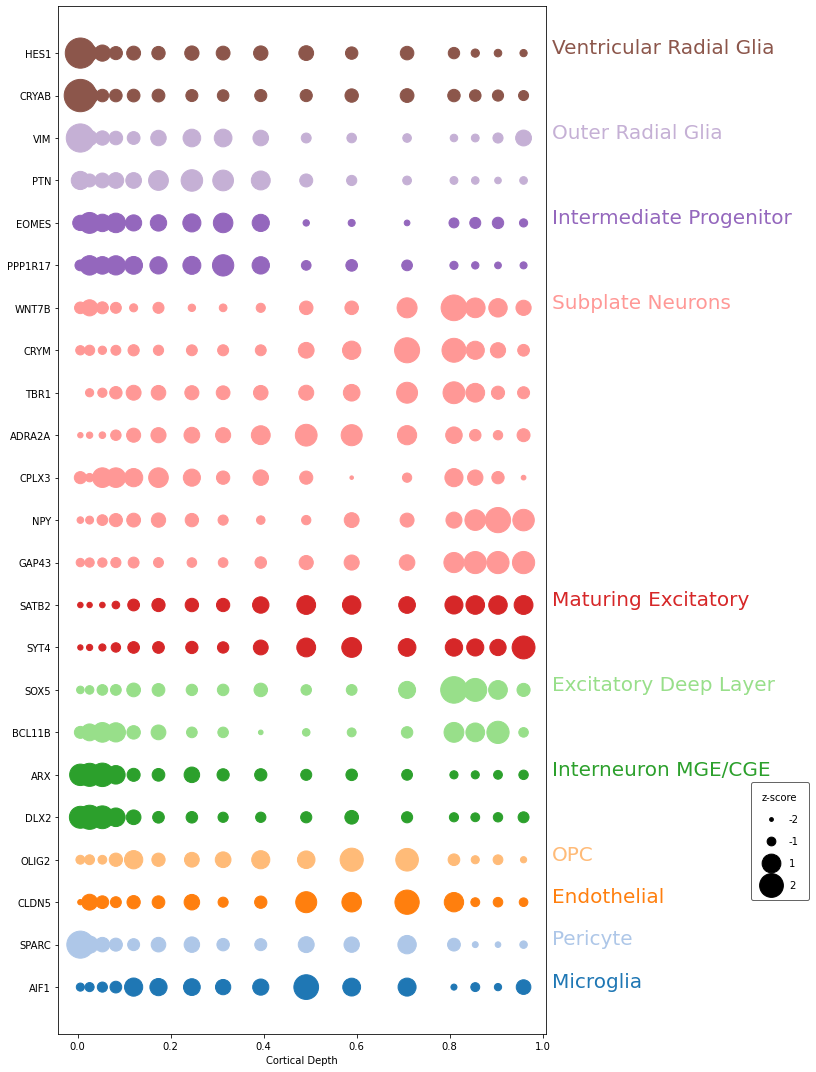

In [33]:
import scipy as sp

markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'VIM', 'PTN',
                          'EOMES', 'PPP1R17', 'WNT7B', 'CRYM','TBR1', 'ADRA2A', 'CPLX3', 'NPY', 'GAP43',
                          'SATB2', 'SYT4', 'SOX5', 'BCL11B',
                          'ARX', 'DLX2', 'OLIG2',
                          'CLDN5', 'SPARC','AIF1')))

celltypes = np.flipud(np.array(('Ventricular Radial Glia', 'Ventricular Radial Glia', 'Outer Radial Glia', 'Outer Radial Glia',
                      'Intermediate Progenitor', 'Intermediate Progenitor', 'Subplate Neurons',
                       'Subplate Neurons','Subplate Neurons', 'Subplate Neurons','Subplate Neurons', 'Subplate Neurons','Subplate Neurons',
                       'Maturing Excitatory', 'Maturing Excitatory', 'Excitatory Deep Layer', 'Excitatory Deep Layer',
                       'Interneuron MGE/CGE', 'Interneuron MGE/CGE', 'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

subset_w = np.where(np.array([metadata_subset['AOI_type'][i] == 'Geometric' and metadata_subset['slide'][i] == '00MU' for i in range(len(metadata_subset['AOI_type']))]))[0]
order = subset_w[np.argsort(metadata_subset['VCDepth'].iloc[subset_w])]

normCounts = np.array([X_data[i,:]/sum(X_data[i,:]) for i in range(np.shape(X_data)[0])])*10**6

markers_index = np.array([np.where(mod1.genes == markers_genes[i])[0][0] for i in range(len(markers_genes))])

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]
counts_z_score = sp.stats.zscore(np.log2(normCounts), axis = 1)

genesForPlot = np.repeat(markers_genes,len(order))
vcForPlot = np.array([metadata_subset['VCDepth'].iloc[order] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([sc.stats.zscore(np.log(normCounts[:,markers_index][order,:].T)[i,:]) for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * len(order)) for i in range(len(unique_celltypes))])

cmap = matplotlib.cm.get_cmap('tab20')

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**2)*25, c = cmap(coloursForPlot))
plt.xlabel('Cortical Depth')
for i in range(len(unique_celltypes)):
    index = np.where([celltypes[j] == unique_celltypes[i] for j in range(len(celltypes))])[0]
    index = index[-1]
    plt.text(1.02, markers_genes[index], celltypes[index], fontsize=20, c = cmap(i))
plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**2)*25, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('celltypeMarkers_vs_corticalDepth.pdf', bbox_extra_artists=(lgd,))

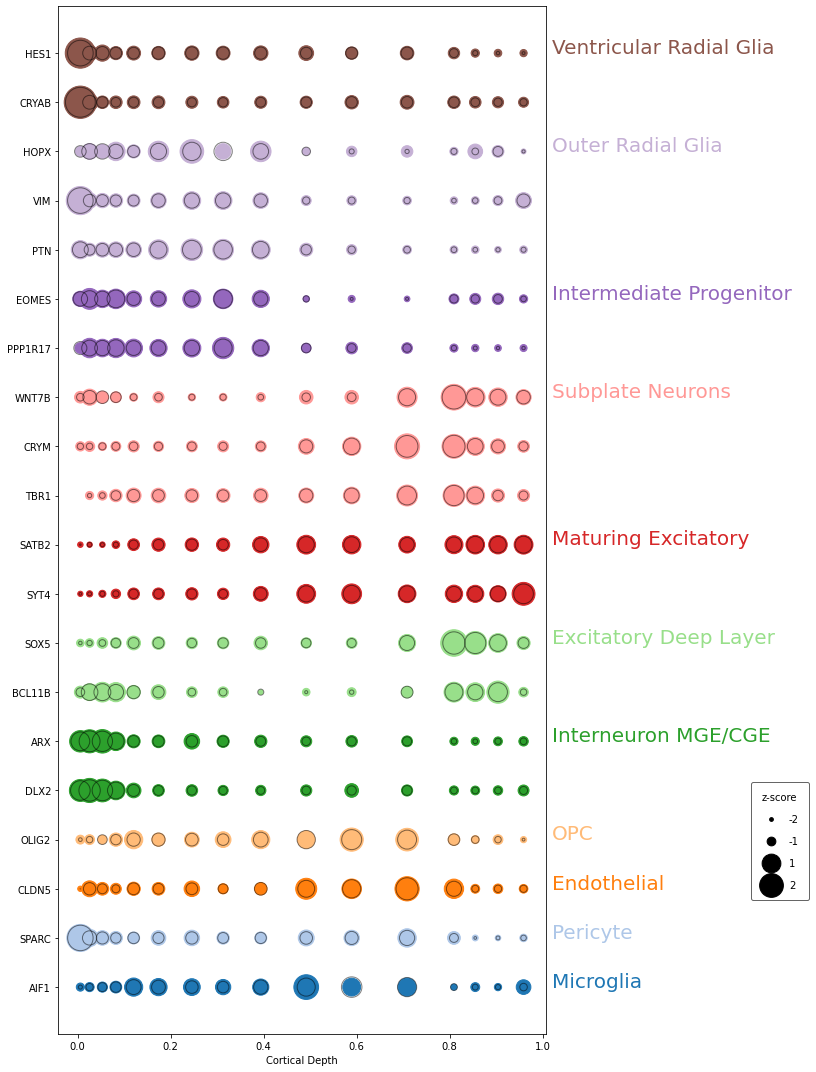

In [41]:
import scipy as sc

markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'HOPX', 'VIM', 'PTN',
                          'EOMES', 'PPP1R17', 'WNT7B', 'CRYM','TBR1',
                          'SATB2', 'SYT4', 'SOX5', 'BCL11B',
                          'ARX', 'DLX2', 'OLIG2',
                          'CLDN5', 'SPARC','AIF1')))


celltypes = np.flipud(np.array(('Ventricular Radial Glia', 'Ventricular Radial Glia', 'Outer Radial Glia', 'Outer Radial Glia', 'Outer Radial Glia',
                      'Intermediate Progenitor', 'Intermediate Progenitor', 'Subplate Neurons', 'Subplate Neurons','Subplate Neurons',
                       'Maturing Excitatory', 'Maturing Excitatory', 'Excitatory Deep Layer', 'Excitatory Deep Layer',
                       'Interneuron MGE/CGE', 'Interneuron MGE/CGE', 'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

subset_w = np.where(np.array([metadata_subset['AOI_type'][i] == 'Geometric' and metadata_subset['slide'][i] == '00MU' for i in range(len(metadata_subset['AOI_type']))]))[0]
order = subset_w[np.argsort(metadata_subset['VCDepth'].iloc[subset_w])]


normCounts1 = np.array([X_data[i,:]/sum(X_data[i,:]) for i in range(np.shape(X_data)[0])])*10**6

normCounts2 = mod1.a_gr_mean

markers_index = np.array([np.where(mod1.genes == markers_genes[i])[0][0] for i in range(len(markers_genes))])

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]
counts_z_score1 = sc.stats.zscore(np.log2(normCounts1), axis = 1)
counts_z_score2 = sc.stats.zscore(np.log2(normCounts2), axis = 1)

genesForPlot = np.repeat(markers_genes,len(order))
vcForPlot = np.array([metadata_subset['VCDepth'].iloc[order] for i in range(len(markers_genes))]).flatten()
countsForPlot1 = np.array([sc.stats.zscore(np.log(normCounts1[:,markers_index][order,:].T)[i,:]) for i in range(len(markers_genes))])
countsForPlot2 = np.array([sc.stats.zscore(np.log(normCounts2[:,markers_index][order,:].T)[i,:]) for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * len(order)) for i in range(len(unique_celltypes))])

cmap = matplotlib.cm.get_cmap('tab20')

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot1) + countsForPlot1)**2)*25, c = cmap(coloursForPlot))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot2) + countsForPlot2)**2)*25, edgecolors='black', facecolors='none', 
            alpha = 0.5)
plt.xlabel('Cortical Depth')
for i in range(len(unique_celltypes)):
    index = np.where([celltypes[j] == unique_celltypes[i] for j in range(len(celltypes))])[0]
    index = index[-1]
    plt.text(1.02, markers_genes[index], celltypes[index], fontsize=20, c = cmap(i))
plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**2)*25, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('celltypeMarkers_vs_corticalDepth_zscore_Comparison.pdf', bbox_extra_artists=(lgd,))

In [ ]:
import scipy as sc

markers_genes = np.flipud(np.array(('INS', 'HES1', 'CRYAB', 'VIM', 'PTN',
                          'EOMES', 'PPP1R17', 'WNT7B', 'CRYM','TBR1',
                          'SATB2', 'SYT4', 'SOX5', 'BCL11B',
                          'ARX', 'DLX2', 'OLIG2',
                          'CLDN5', 'SPARC','AIF1')))


celltypes = np.flipud(np.array(('Beta cell', 'Ventricular Radial Glia', 'Ventricular Radial Glia', 'Outer Radial Glia', 'Outer Radial Glia',
                      'Intermediate Progenitor', 'Intermediate Progenitor', 'Subplate Neurons', 'Subplate Neurons','Subplate Neurons',
                       'Maturing Excitatory', 'Maturing Excitatory', 'Excitatory Deep Layer', 'Excitatory Deep Layer',
                       'Interneuron MGE/CGE', 'Interneuron MGE/CGE', 'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

subset_w = np.where(np.array([metadata_subset['AOI_type'][i] == 'Geometric' and metadata_subset['slide'][i] == '00MU' for i in range(len(metadata_subset['AOI_type']))]))[0]
order = subset_w[np.argsort(metadata_subset['VCDepth'].iloc[subset_w])]


normCounts1 = np.array([X_data[i,:]/sum(X_data[i,:]) for i in range(np.shape(X_data)[0])])*10**6

normCounts2 = np.array([mod1.a_gr_mean[i,:]/sum(mod1.a_gr_mean[i,:]) for i in range(np.shape(mod1.a_gr_mean)[0])])*10**6

markers_index = np.array([np.where(mod1.genes == markers_genes[i])[0][0] for i in range(len(markers_genes))])

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]
counts_z_score1 = sc.stats.zscore(np.log2(normCounts1), axis = 1)
counts_z_score2 = sc.stats.zscore(np.log2(normCounts2), axis = 1)

genesForPlot = np.repeat(markers_genes,len(order))
vcForPlot = np.array([metadata_subset['VCDepth'].iloc[order] for i in range(len(markers_genes))]).flatten()
countsForPlot1 = np.array([normCounts1[:,markers_index][order,:].T[i,:] for i in range(len(markers_genes))])
countsForPlot2 = np.array([normCounts2[:,markers_index][order,:].T[i,:] for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * len(order)) for i in range(len(unique_celltypes))])

cmap = matplotlib.cm.get_cmap('tab20')

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((countsForPlot1)), c = cmap(coloursForPlot))
plt.scatter(vcForPlot, genesForPlot, s=((countsForPlot2)), edgecolors='black', facecolors='none', 
            alpha = 0.5)
plt.xlabel('Cortical Depth')
for i in range(len(unique_celltypes)):
    index = np.where([celltypes[j] == unique_celltypes[i] for j in range(len(celltypes))])[0]
    index = index[-1]
    plt.text(1.02, markers_genes[index], celltypes[index], fontsize=20, c = cmap(i))
plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**2)*25, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="cpm", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('celltypeMarkers_vs_corticalDepth_cpm_Comparison.pdf', bbox_extra_artists=(lgd,))

In [21]:
np.shape(X_data)

(112, 18119)

In [49]:
np.shape(mod1.a_gr_mean)

(112, 18119)

In [19]:
# -*- coding: utf-8 -*-
"""Default Generative Model for GeoMx counts"""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from functools import wraps
from adjustText import adjust_text
import matplotlib.cm as cm

from pycell2location.models.pymc3_model import Pymc3Model 

# defining the model itself
class GeoMxCountsV1(Pymc3Model):
    r"""GeoMx Generative Model:
    :param X_data: Numpy array of gene probe counts (cols) in ROIs (rows)
    :param Y_data: Numpy array of negative probe counts (cols) in ROIs (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    """

    def __init__(
        self,
        X_data: np.ndarray,
        Y_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 200000,
        learning_rate = 0.001,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        n_factors = 7,
        cutoff_poisson = 1000,
        h_alpha = 1
    ):
        
        ############# Initialise parameters ################
        super().__init__(X_data, 0,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)
        self.Y_data = Y_data
        self.y_data = theano.shared(Y_data.astype(self.data_type))
        self.n_rois = Y_data.shape[0]
        self.l_r = np.array([np.sum(X_data[i,:]) for i in range(self.n_rois)]).reshape(self.n_rois,1)/self.n_genes
        self.n_factors = n_factors
        self.n_npro = Y_data.shape[1]
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        self.X_data1 = self.X_data[self.poisson_residual]
        self.X_data2 = self.X_data[self.gamma_residual]
        self.genes = var_names
        self.sample_names = obs_names
        self.h_alpha = h_alpha
        
        ############# Define the model ################
        self.model = pm.Model()
        with self.model:
            
            ### Negative Probe Counts ###
            
            # Prior for distribution of negative probe count levels:
            self.b_n_hyper = pm.Gamma('b_n_hyper', alpha = np.array((3,1)), beta = np.array((1,1)), shape = 2)
            self.b_n = pm.Gamma('b_n', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_npro))
            self.y_rn = self.b_n*self.l_r
            
            ### Gene Counts ###
            
            # Background for gene probes, drawn from the same distribution as negative probes:
            self.b_g = pm.Gamma('b_g', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_genes))

            # Gene expression modeled as combination of non-negative factors:
            self.h_hyp = pm.Gamma('h_hyp', 1, 1, shape = 1)
            self.h = pm.Gamma('h', alpha = 1, beta = self.h_hyp, shape=(self.n_genes, self.n_factors))
            self.w_hyp = pm.Gamma('w_hyp', np.array((1,1)), np.array((1,1)), shape=(self.n_factors,2))
            self.w = pm.Gamma('w', mu=self.w_hyp[:,0], sigma=self.w_hyp[:,1], shape=(self.n_rois, self.n_factors))
            self.a_gr =  pm.Deterministic('a_gr', pm.math.dot(self.w, self.h.T))
            
            # Expected gene counts are sum of gene expression and background counts, scaled by library size:
            self.x_rg = (self.a_gr + self.b_g)*self.l_r
            
            self.data_target = pm.DensityDist('data_target', self.get_logDensity, observed=tt.concatenate([self.y_data, self.x_data], axis = 1))
    
    
    def get_logDensity(self,x):
        # Likelihood function combines likelihood for negative probes and gene probes and replaces poisson sampling
        # for gamma distribution for very high counts (for numerical stability)
            mu1 = self.y_rn
            mu2 = self.x_rg[self.poisson_residual]
            mu3 = self.x_rg[self.gamma_residual]
            logDensity = tt.sum(pm.Poisson.dist(mu1).logp(x[:,:self.n_npro])) + tt.sum(pm.Poisson.dist(mu2).logp(x[:,self.n_npro:][self.poisson_residual])) + tt.sum(pm.Gamma.dist(mu = mu3, sd = tt.sqrt(mu3)).logp(x[:,self.n_npro:][self.gamma_residual]))
            return logDensity
    
    def compute_expected(self):
        r""" Save expected value of negative probe poisson mean and negative probe level"""
        # compute poisson mean of negative probes:
        self.y_rn_mean = self.samples['post_sample_means']['b_n'] * self.l_r
        # compute poisson mean of unnormalized gene probe counts:
        self.x_rg_mean = (self.samples['post_sample_means']['a_gr'] + self.samples['post_sample_means']['b_g'])*self.l_r
        
    def compute_logFC(self, groupA = 3, groupB = 6, n_samples = 1000):
        r"""Compute log-fold change of genes between two ROIs or two groups of ROIs, as well as associated
        standard deviation and 0.05 and 0.95 percentile"""
        groupA = np.squeeze(groupA)
        groupB = np.squeeze(groupB)
        post_sample_a_gr = self.mean_field['init_1'].sample_node(self.a_gr, size = n_samples).eval()
        self.logFC = pd.DataFrame(index = self.genes, columns = ('groupA', 'groupB', 'mean', 'sd', 'q05', 'q95'))
        
        if sum(np.shape(groupA)) < 2:
            groupA_value = np.log2(post_sample_a_gr[:,groupA,:])
            self.logFC['groupA'] = self.sample_names[groupA]
        else:
            groupA_value = np.log2(np.mean(post_sample_a_gr[:,groupA,:], axis = 1))
            self.logFC['groupA'] = ', '.join(self.sample_names[groupA])
        if sum(np.shape(groupB)) < 2:
            groupB_value = np.log2(post_sample_a_gr[:,groupB,:])
            self.logFC['groupB'] = self.sample_names[groupB]
        else:
            groupB_value = np.log2(np.mean(post_sample_a_gr[:,groupB,:], axis = 1))
            self.logFC['groupB'] = ', '.join(self.sample_names[groupB])
        
        self.logFC_sample =  groupA_value - groupB_value
        self.logFC['mean'] = self.logFC_sample.mean(axis=0)
        self.logFC['sd'] = self.logFC_sample.std(axis=0) 
        self.logFC['q05'] = np.quantile(self.logFC_sample, 0.05, axis=0)
        self.logFC['q95'] = np.quantile(self.logFC_sample, 0.95, axis=0)  
        
    def compute_FDR(self, logFC_threshold = 1):
        r"""Compute probability that logFC is above a certain threshold 
        and also include FDR for each probability level.
        :logFC_threshold: logFC threshold above which we define a discovery"""
        self.logFC['threshold'] = logFC_threshold
        self.logFC['probability'] = np.sum(np.abs(self.logFC_sample) > logFC_threshold, axis = 0)/np.shape(self.logFC_sample)[0]
        probability = self.logFC['probability']
        self.logFC['FDR'] = np.array([sum(1-probability[probability >= p])/sum(probability >= p) for p in probability])
        self.logFC = self.logFC.sort_values('FDR')
    
    def plot_volcano(self, genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                     height = 10, width = 10):
        r""" Make a volcano plot of the differential expression analysis.
        :genesOfInterest: numpy array of genes to annotate in the plot
        :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
        i.e. the most differentially expressed genes
        :alpha: transparency of dots 
        :FDR_cutoff: what false discovery rate to use
        :height: height of figure
        :width: width of figure
        """
        
        # Set figure parameters:
        SMALL_SIZE = 20
        MEDIUM_SIZE = 20
        BIGGER_SIZE = 20
        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
        plt.figure(figsize=(width,height))
        colours = np.repeat('grey', self.n_genes)
        colours[[self.logFC['mean'][i] > 0 and self.logFC['FDR'][i] < FDR_cutoff for i in range(len(self.logFC['mean']))]] = 'blue'
        colours[[self.logFC['mean'][i] < 0 and self.logFC['FDR'][i] < FDR_cutoff for i in range(len(self.logFC['mean']))]] = 'red'
        plt.scatter(self.logFC['mean'], -np.log10(1-self.logFC['probability']+0.0001), c=colours, alpha = 0.1)
        #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
        #           np.amax(self.logFC['mean']), linestyles = 'dashed')
        #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
        #         'FDR < ' + str(FDR_cutoff))
        plt.xlabel('Log2FC')
        plt.ylim(0,3.5)
        plt.ylabel('-log10(P(Log2FC > ' + str(self.logFC['threshold'][0]) + '))')
        
        if n_max_genes > 0:
            
            maxGenes = np.array((self.logFC.index[np.argmax(self.logFC['mean'])],
                                 self.logFC.index[np.argmin(self.logFC['mean'])]))
        if genesOfInterest is None:
            
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes))
        
        if genesOfInterest is not None:
        
            geneIndex_to_annotate = np.squeeze([np.where(self.logFC.index == genesOfInterest[i])
                                                for i in range(len(genesOfInterest))])
            
            ts = []    
            for i,j in enumerate(geneIndex_to_annotate):
                ts.append(plt.text(self.logFC['mean'][j], -np.log10(1-self.logFC['probability'][j]), genesOfInterest[i]))
            adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 2.5,
                       force_points = 2.5, force_objects = 2.5)
        
        plt.show()
        
        
    def plot_Log2FC_vs_sd(self, genesOfInterest = None, n_max_genes = 3, ylim = None):
        r""" Make a volcano plot of the differential expression analysis.
        :genesOfInterest: numpy array of genes to annotate in the plot
        :n_max_genes: number of genes to annotate at the extreme ends of the plot,
        i.e. the most differentially expressed genes
        """
        
        # Set figure parameters:
        SMALL_SIZE = 20
        MEDIUM_SIZE = 20
        BIGGER_SIZE = 20

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
        f = plt.figure(figsize=(20,10))
        colours = np.repeat('grey', self.n_genes)
        colours[[self.logFC['mean'][i] > 0 and self.logFC['FDR'][i] < 0.05 for i in range(len(self.logFC['mean']))]] = 'blue'
        colours[[self.logFC['mean'][i] < 0 and self.logFC['FDR'][i] < 0.05 for i in range(len(self.logFC['mean']))]] = 'red'
        plt.scatter(self.logFC['mean'], self.logFC['sd'], c = colours)
        plt.xlabel('Log2FC_mean')
        plt.ylabel('Log2FC_sd')    
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(plt.text(self.logFC['mean'][j], self.logFC['sd'][j], genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 1.5, force_objects = 1, force_points = 1)    
        plt.show()    
        
    def plot_factor_weights(self, order = None):
        r""" Plot the factor weights in a heatmap, with the rows (factors) cluster and the samples in the order provided
        :genesOfInterest: numpy array of order (indexes) to put the samples in the heatmap, 
        if None then no reordering will take place
        """ 
        if order is None:
            order = np.arrange(1,len())
        w = self.samples['post_sample_means']['w'][order,:]
        sns.clustermap(w.T, col_cluster=False)        
        
    def plot_negativeProbes_vs_geneBackground(self, samples, n_bins = 100, n_samples = 1000):
        r""" Plot histogram of the negative probe counts and the poisterior poisson mean of background counts
        across all genes
        :samples: numpy array with sequence of samples for which to do this plot
        :n_bins: number of bins for the geneBackground histogram
        :n_samples: number of samples to use for approximating posterior distribution of gene background
        """
        post_sample_b_g = self.mean_field['init_1'].sample_node(self.b_g, size = n_samples).eval()
        
        fig, ax = plt.subplots(2, sharex=True)
        fig.suptitle('Negative Probe Counts and Posterior Poisson Mean of all Background Counts')
        
        for i in range(len(samples)):
            ax[0].hist(self.Y_data[:,samples[i]], bins = 10, alpha = 0.75)
        
        ax[0].set_ylabel('Number of Probes')
        
        for i in range(len(samples)):        
            ax[1].hist(np.squeeze(post_sample_b_g[:,:,:]*self.l_r[samples[i]]).flatten(),
                       bins = n_bins, density = True, label = 'sample ' + str(i), alpha = 0.75)

        ax[1].set_xlabel('Counts')
        ax[1].set_ylabel('Probability Density')
        ax[1].set_xscale('log')
        ax[1].legend()
        plt.show()                            
                                              
    def plot_single_geneCounts_and_poissonMean(self, gene, samples, n_samples = 1000):
        r""" Plot a scatter plot of gene counts and a histogram of predicted poisson mean
        :gene: which example gene to plot
        :samples: numpy array with sequence of samples for which to do this plot, maximum is 6
        :n_samples: how many samples to take to approximate posterior
        """
        
        post_sample_a_gr = self.mean_field['init_1'].sample_node(self.a_gr, size = n_samples).eval()
        post_sample_b_g = self.mean_field['init_1'].sample_node(self.b_g, size = n_samples).eval()
        
        if len(samples) > 5:
            print('Maximum Number of Samples is 6')
        colourPalette = c('blue', 'green', 'red', 'yellow', 'black', 'grey')
        
        fig, ax = plt.subplots(2, sharex=True)
        fig.suptitle('Raw Counts and Posterior Poisson Mean of Gene Counts (' + gene + ')')
        ax[0].scatter(X_data[samples, self.genes == gene], ('Sample1','Sample2'),  40,
                      c = [colourPalette[i] for i in range(len(samples))])
        
        for i in range(len(samples)):
            ax[1].hist(np.squeeze(post_sample_a_gr[:,i,self.genes == gene]*self.l_r[i]),
                       bins = n_bins, density = True, label = 'sample 1', color = 'blue')
        
        ax[1].set_xlabel('Counts')
        ax[1].set_ylabel('Probability Density')
        ax[1].legend()

        fig, ax = plt.subplots(2, sharex=True)
        fig.suptitle('Negative Probe Counts and Posterior Poisson Mean of Background Counts (' + gene + ')')
        
        for i in range(len(samples)):
            ax[0].hist(negProbes_subset[:,samples[i]], color = 'blue', bins = 100, alpha = 0.5)        
        
        ax[0].set_ylabel('Number of Probes')
        
        for i in range(len(samples)):
        
            ax[1].hist(np.squeeze(post_sample_b_g[:,:, self.genes == gene]*self.l_r[samples[i]]), bins = 10,
                       density = True, label = 'sample ' + str(i), color = 'blue', alpha = 0.75)

        ax[1].set_xlabel('Counts')
        ax[1].set_ylabel('Probability Density')
        ax[1].set_xscale('log')
        ax[1].legend()
    
    def plot_multiple_geneCounts_and_PoissonMean(self, gene, samples):
        r""" Plot histogram of the negative probe counts anad the predicted gene backgrounds counts
        across all genes
        :samples: numpy array with sequence of samples for which to do this plot
        """
        print('test')
    

In [20]:
GeoMxCountsV1.compute_logFC(mod1)
GeoMxCountsV1.compute_FDR(mod1)

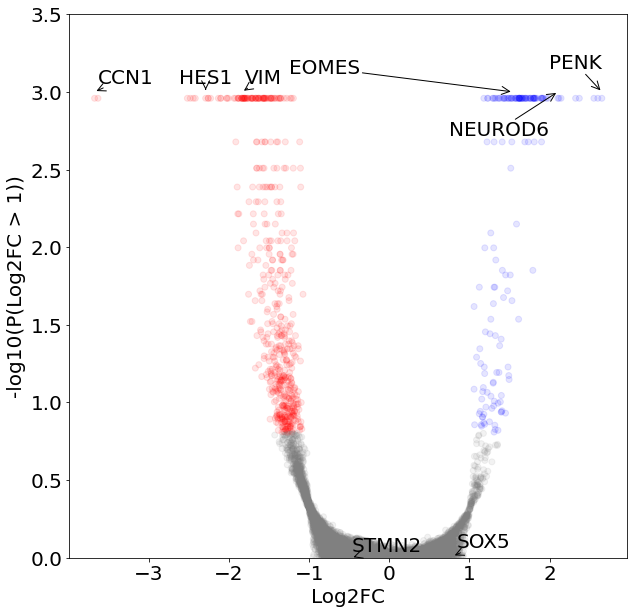

In [22]:
genesOfInterest = np.array(['HES1', 'VIM',  'EOMES', 'STMN2', 'NEUROD6', 'SOX5'])
GeoMxCountsV1.plot_volcano(mod1, genesOfInterest = genesOfInterest, n_max_genes = 3)

In [21]:
tab = pd.read_csv('/nfs/team283/aa16/KR_NAS/DEseq_results.csv')

In [29]:
genes_DeSeq = pd.read_csv('/nfs/team283/aa16/KR_NAS/DEseq_genes.csv')

In [33]:
genes_DeSeq = np.array(genes_DeSeq['x'])

In [22]:
tab

Unnamed: 0   baseMean  log2FoldChange     lfcSE      stat  \
0               1  14.081733       -0.296454  0.200378 -1.479476   
1               2  15.615790       -0.001595  0.174763 -0.009127   
2               3  17.558840        0.452458  0.167674  2.698429   
3               4  11.948233       -0.100417  0.194896 -0.515230   
4               5   8.998798       -0.038836  0.227111 -0.170999   
...           ...        ...             ...       ...       ...   
18313       18314  10.978876       -0.237437  0.209565 -1.132998   
18314       18315  24.043030        0.061686  0.153071  0.402993   
18315       18316  46.950848        0.690667  0.110102  6.272997   
18316       18317  25.205304       -0.190443  0.151431 -1.257616   
18317       18318  25.268751       -0.003396  0.138482 -0.024521   

             pvalue          padj  
0      1.390131e-01           NaN  
1      9.927181e-01  9.984615e-01  
2      6.966769e-03  6.046073e-02  
3      6.063921e-01           NaN  
4      8.642243e-01           NaN  
...             ...           ...  
18313  2.572149e-01           NaN  
18314  6.869536e-01  8.993380e-01  
18315  3.541635e-10  1.504888e-08  
18316  2.085307e-01  5.583856e-01  
18317  9.804370e-01  9.955221e-01  

[18318 rows x 7 columns]

In [24]:
import statsmodels.stats.multitest as multi
tab['FDR'] = multi.multipletests(tab['pvalue'], method = 'fdr_bh')[1]

In [28]:
sum([abs(tab['log2FoldChange'])[i] > 1 and tab['FDR'][i] < 0.05 for i in range(len(tab['FDR']))])

199

In [59]:
n_max_genes = 0
alpha = 0.25
FDR_cutoff = 0.05
height = 10
width = 10

In [105]:
tab['log2FoldChange'] = -tab['log2FoldChange']

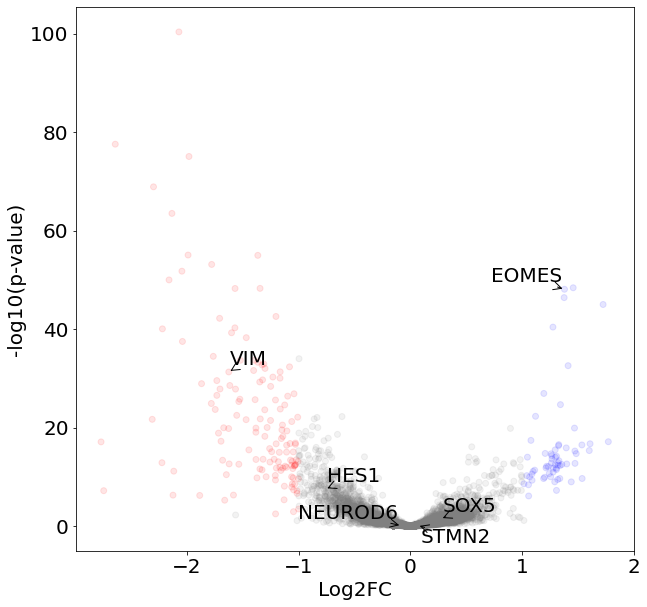

In [106]:
# Set figure parameters:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(width,height))
colours = np.repeat('grey', np.shape(genes_DeSeq)[0])
colours[[tab['log2FoldChange'][i] > 1 and tab['FDR'][i] < 0.05 for i in range(len(tab['FDR']))]] = 'blue'
colours[[tab['log2FoldChange'][i] < -1 and tab['FDR'][i] < 0.05 for i in range(len(tab['FDR']))]] = 'red'        
plt.scatter(tab['log2FoldChange'], -np.log10(tab['pvalue']), c=colours, alpha = 0.1)
# plt.hlines(np.amin(-np.log10(tab['pvalue'][tab['FDR'] < 0.05])), np.amin(tab['log2FoldChange']),
#            np.amax(tab['log2FoldChange']), linestyles = 'dashed')
# plt.text(np.amin(tab['log2FoldChange']),-np.log10(np.amin(tab['pvalue'][tab['FDR'] < 0.05])) + 0.01,
#          'FDR < ' + str(0.05))
plt.xlabel('Log2FC')
plt.ylabel('-log10(p-value)')

geneIndex_to_annotate = np.squeeze([np.where(genes_DeSeq == genesOfInterest[i])
                                    for i in range(len(genesOfInterest))])

ts = []    
for i,j in enumerate(geneIndex_to_annotate):
    ts.append(plt.text(tab['log2FoldChange'][j], -np.log10(tab['pvalue'])[j], genesOfInterest[i]))
adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 1.5,
           force_points = 1.5, force_objects = 1.5)

plt.show()
        

In [71]:
-np.log10(tab['pvalue'])

0        0.856944
1        0.003174
2        2.156969
3        0.217246
4        0.063374
           ...   
18313    0.589704
18314    0.163073
18315    9.450796
18316    0.680830
18317    0.008580
Name: pvalue, Length: 18318, dtype: float64

In [91]:
sum(mod1.logFC['probability'] == 0.999)

166

In [93]:
np.amax(tab['pvalue'][tab['FDR'] < 0.05])

0.00340605096787135

In [48]:
counts_denoised = np.round(mod1.l_r*mod1.a_gr_mean)

In [38]:
mod1.a_gr_mean[1:5,1:5]

array([[0.1580472 , 0.29802072, 0.05850564, 0.06167963],
       [0.14519107, 0.32972735, 0.06174081, 0.06596629],
       [0.09544063, 0.17363425, 0.04752877, 0.03768803],
       [0.08184218, 0.20340809, 0.04462002, 0.0383331 ]], dtype=float32)

In [39]:
mod1.l_r[1:5]

array([[665.3577],
       [682.9424],
       [ 77.2437],
       [127.5642]])

In [45]:
0.0475*77.24

3.6689

In [46]:
np.shape(mod1.a_gr_mean)

(112, 18119)